## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [1]:
import os
import keras
import itertools
# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], pre_activate=False):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, name=f"hidden_layer{i+1}")(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, name=f"hidden_layer{i+1}")(x)
            
        if pre_activate:
            x = BatchNormalization()(x)
            x = keras.layers.Activation("relu")(x)
        else:
            x = keras.layers.Activation("relu")(x)
            x = BatchNormalization()(x)
            
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 15
BATCH_SIZE = [2, 16, 32, 128, 256]
PRE_ACTIVATE = [True, False]
MOMENTUM = 0.95

In [7]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for i, (pre_activate, batch_size) in enumerate(itertools.product(PRE_ACTIVATE, BATCH_SIZE)):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print(f"Experiment with PRE_ACTIVATE = {pre_activate} and BATCH_SIZE = {batch_size}")
    model = build_mlp(input_shape=x_train.shape[1:], pre_activate=pre_activate)
    model.summary()
    
    opt = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    
    model.fit(x_train, 
              y_train, 
              epochs=EPOCHS, 
              batch_size=batch_size, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}
    

W0720 02:07:20.198840  6180 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0720 02:07:20.199836  6180 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0720 02:07:20.215835  6180 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0720 02:07:20.217823  6180 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0720 02:07:20.219838  6180 depr

Experiment with PRE_ACTIVATE = True and BATCH_SIZE = 2


W0720 02:07:20.525735  6180 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0720 02:07:20.637700  6180 deprecation.py:323] From C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
__________

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 13s 259us/step - loss: 1.6660 - acc: 0.4082 - val_loss: 1.5930 - val_acc: 0.4276
Epoch 2/15
50000/50000 [==============================] - 12s 246us/step - loss: 1.4363 - acc: 0.4914 - val_loss: 1.6407 - val_acc: 0.4177
Epoch 3/15
50000/50000 [==============================] - 12s 247us/step - loss: 1.3347 - acc: 0.5264 - val_loss: 1.6680 - val_acc: 0.4253
Epoch 4/15
50000/50000 [==============================] - 12s 247us/step - loss: 1.2588 - acc: 0.5553 - val_loss: 1.5758 - val_acc: 0.4624
Epoch 5/15
50000/50000 [==============================] - 12s 247us/step - loss: 1.1914 - acc: 0.5771 - val_loss: 1.5884 - val_acc: 0.4419
Epoch 6/15
50000/50000 [==============================] - 12s 248us/step - loss: 1.1372 - acc: 0.5975 - val_loss: 1.4176 - val_acc: 0.4988
Epoch 7/15
50000/50000 [==============================] - 12s 247us/step - loss: 1.0830 - acc: 0.6159 - val_loss: 1.

50000/50000 [==============================] - 3s 61us/step - loss: 1.5417 - acc: 0.4612 - val_loss: 1.5707 - val_acc: 0.4477
Epoch 3/15
50000/50000 [==============================] - 3s 61us/step - loss: 1.4245 - acc: 0.5048 - val_loss: 1.5306 - val_acc: 0.4650
Epoch 4/15
50000/50000 [==============================] - 3s 61us/step - loss: 1.3376 - acc: 0.5357 - val_loss: 1.4958 - val_acc: 0.4679
Epoch 5/15
50000/50000 [==============================] - 3s 61us/step - loss: 1.2656 - acc: 0.5623 - val_loss: 1.5008 - val_acc: 0.4677
Epoch 6/15
50000/50000 [==============================] - 3s 61us/step - loss: 1.1981 - acc: 0.5878 - val_loss: 1.4652 - val_acc: 0.4813
Epoch 7/15
50000/50000 [==============================] - 3s 61us/step - loss: 1.1363 - acc: 0.6116 - val_loss: 1.5273 - val_acc: 0.4632
Epoch 8/15
50000/50000 [==============================] - 3s 61us/step - loss: 1.0779 - acc: 0.6303 - val_loss: 1.4372 - val_acc: 0.4891
Epoch 9/15
50000/50000 [============================

Epoch 4/15
50000/50000 [==============================] - 25s 492us/step - loss: 1.5508 - acc: 0.4477 - val_loss: 1.5624 - val_acc: 0.4433
Epoch 5/15
50000/50000 [==============================] - 25s 491us/step - loss: 1.5292 - acc: 0.4557 - val_loss: 1.6101 - val_acc: 0.4272
Epoch 6/15
50000/50000 [==============================] - 25s 495us/step - loss: 1.4936 - acc: 0.4683 - val_loss: 1.5383 - val_acc: 0.4527
Epoch 7/15
50000/50000 [==============================] - 25s 490us/step - loss: 1.4612 - acc: 0.4803 - val_loss: 1.4838 - val_acc: 0.4728
Epoch 8/15
50000/50000 [==============================] - 25s 494us/step - loss: 1.4320 - acc: 0.4887 - val_loss: 1.4818 - val_acc: 0.4720
Epoch 9/15
50000/50000 [==============================] - 25s 491us/step - loss: 1.4095 - acc: 0.4994 - val_loss: 1.4180 - val_acc: 0.4944
Epoch 10/15
50000/50000 [==============================] - 25s 500us/step - loss: 1.3900 - acc: 0.5073 - val_loss: 1.4401 - val_acc: 0.4923
Epoch 11/15
50000/50000 [=

50000/50000 [==============================] - 5s 92us/step - loss: 1.2789 - acc: 0.5508 - val_loss: 1.5560 - val_acc: 0.4594
Epoch 6/15
50000/50000 [==============================] - 5s 92us/step - loss: 1.2358 - acc: 0.5671 - val_loss: 1.4943 - val_acc: 0.4787
Epoch 7/15
50000/50000 [==============================] - 5s 92us/step - loss: 1.1812 - acc: 0.5880 - val_loss: 1.5625 - val_acc: 0.4539
Epoch 8/15
50000/50000 [==============================] - 5s 93us/step - loss: 1.1467 - acc: 0.5969 - val_loss: 1.4969 - val_acc: 0.4757
Epoch 9/15
50000/50000 [==============================] - 5s 93us/step - loss: 1.1071 - acc: 0.6125 - val_loss: 1.5234 - val_acc: 0.4801
Epoch 10/15
50000/50000 [==============================] - 5s 93us/step - loss: 1.0624 - acc: 0.6285 - val_loss: 1.5041 - val_acc: 0.4851
Epoch 11/15
50000/50000 [==============================] - 5s 92us/step - loss: 1.0246 - acc: 0.6425 - val_loss: 1.5829 - val_acc: 0.4639
Epoch 12/15
50000/50000 [=========================

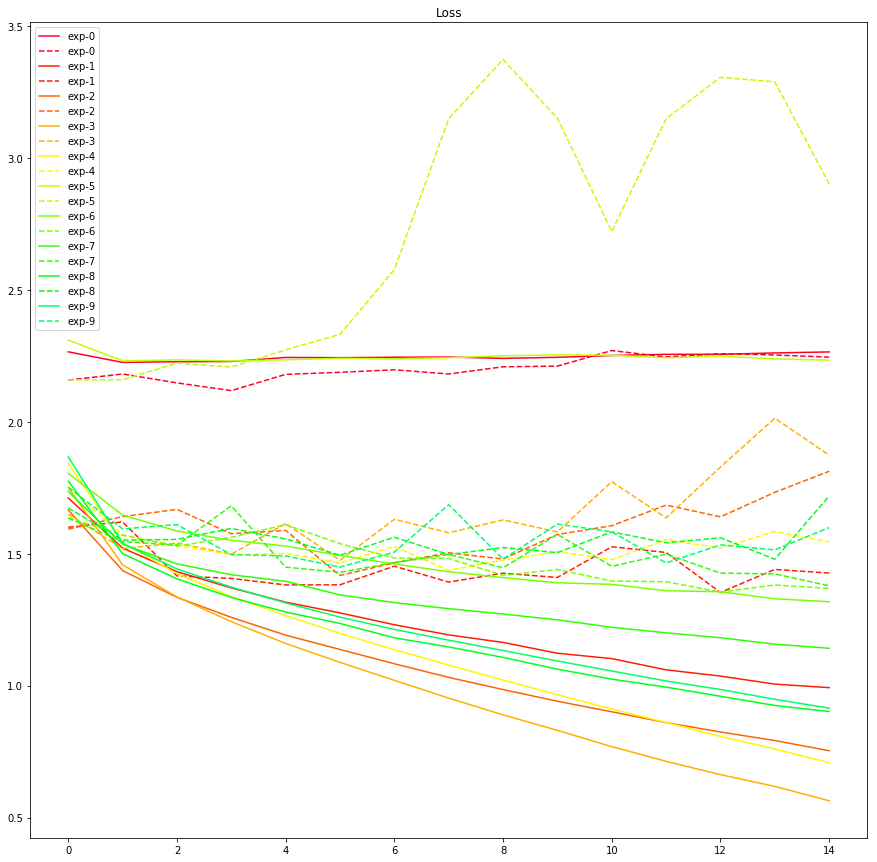

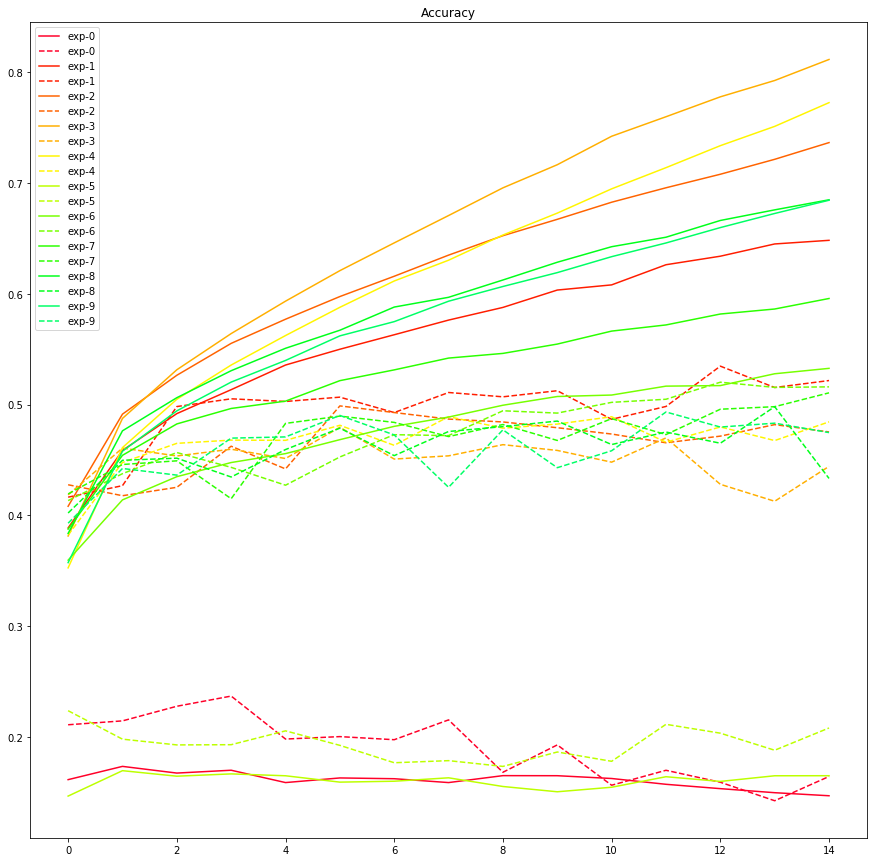

In [8]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline

"""Code Here
將結果繪出
"""
NUM_COLORS = 20

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(15, 15))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(15, 15))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()